# **Optimization Planner Examples**
### In this tutorial we use optimization method to solve planning problems.
### We will start with planning on a point-mass vehicle given a priori decision using convex optimization. If you are not familiar convex optimization, please refer to <a href="https://zhuanlan.zhihu.com/p/37108430" target="_blank">理解凸优化</a> and <a href="https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf" target="_blank">convex optimization</a>. We will be using <a href="https://www.cvxpy.org/" target="_blank">cvxpy</a> as solver.
### After solving this problem with the point-mass model, we will try to solve the same problem with a linearized version of <a href="https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/-/blob/master/vehicleModels_commonRoad.pdf" target="_blank">KST model</a>, where we first optimize lateral waypoints and then optimize longitudinal displacement and speed.
### Finally, we will lose the priori decision and utilize nonlinear optimization to solve the problem with SEMI_TRAILER model using <a href="https://web.casadi.org/" target="_blank">CasADi</a> as a solver.



In [1]:
import os, sys
import matplotlib.pyplot as plt
import argparse
import time
import math
import cvxpy as cp
from itac import *
from SMP.motion_planner.motion_planner import MotionPlanner, MotionPlannerType  # NOQA
from SMP.motion_planner.utility import plot_primitives,create_trajectory_from_list_states  # NOQA
from SMP.maneuver_automaton.maneuver_automaton import ManeuverAutomaton  # NOQA
import optimization_planner_example_utils as opt_utils
from optimization_planner_example_utils import *


### change to root dir
os.chdir(os.getenv('ITAC_ROOT'))

***
## **1. Point-mass Model with Convex Optimization**
***
#### In this example we utilize convex optimization to solve a trajectory planning problem with a point-mass model given a priori decision. The priori decision is to: 
* #### change to left lane;
* #### overtake the obstacle trying to reach max speed.

### **1.1 Set up point-mass constraints and parameters**

In [2]:
# get constraints
c = opt_utils.ConstraintsPointMass()
c.x_s_min = -30  # feasible x displacement of vehicle
c.x_s_max = 200  # feasible x displacement of vehicle
c.x_l_min = -7 # feasible y displacement of vehicle
c.x_l_max = 7 # feasible y displacement of vehicle

c.v_s_min = 0  # feasible x velocity of vehicle
c.v_s_max = 40 # feasible x velocity of vehicle
c.v_l_min = -1.5 # feasible y velocity of vehicle
c.v_l_max = 1.5 # feasible y velocity of vehiclez

c.a_s_min = -6 # feasible x acceleration of vehicle
c.a_s_max =  6 # feasible x acceleration of vehicle
c.a_l_min =  -1.0 # feasible y acceleration of vehicle
c.a_l_max =  1.0 # feasible y acceleration of vehicle

# get ego paramteres
vehicle3 = parameters_sedan.parameters_sedan()
class EgoParameters:
    length = vehicle3.l
    width = vehicle3.w
ep = EgoParameters()

### **1.2 Load scenario and visualize**

In [3]:
## Load the scenario.
file_path = 'tutorial/test_scenarios/itac_optimization_planner_example.xml'
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# problem dimensions
N  = 50  # number of time steps
dT = scenario.dt  # time step

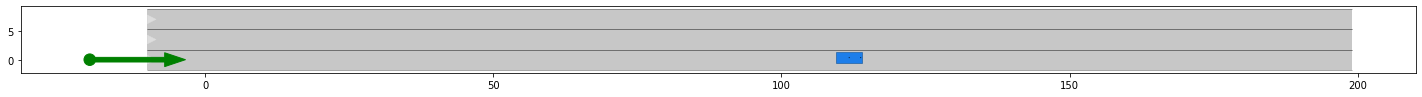

In [4]:
## Plot the scenario for each time step.
from IPython import display
plt.ion()
plt.figure(figsize=(25, 10))
for i in range(0, N):
    plt.figure(figsize=(25, 10))
    display.clear_output(wait=True)
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    planning_problem_set.draw(rnd)
    rnd.render()
    plt.pause(0.1)

### **1.3 Extract obstacle from scenario**
#### **Please be noted that**: in the dummy scenario above, the lanes are straight and parallel to the $x$ axis under global coordinate system, so we directly use the 'points under global coordinate system' as 'points under frenet coordinate system' for simplicity.
#### In real scenarios, you will need to transform the points between the two coordinate systems, check <a href="https://commonroad.in.tum.de/docs/commonroad-drivability-checker/sphinx/06_curvilinear_coordinate_system.html#" target="_blank">commonroad_dc</a> for instructions.



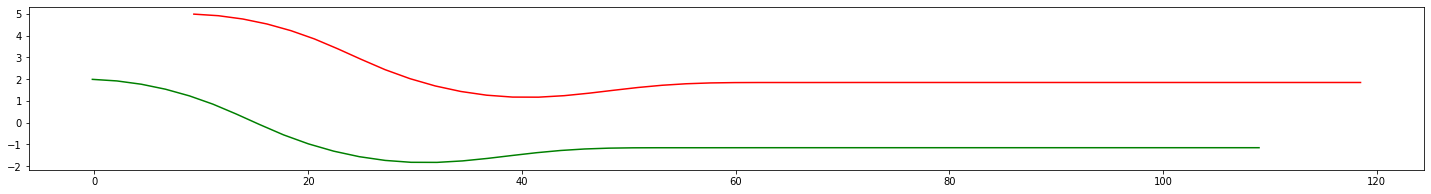

In [5]:
## Get longitudinal and lateral boundaries of dynamic obstacles in each time step, 
## here we are assuming that the obstacles are observed through out the N time steps with no missings.
dyn_obstacles = scenario.dynamic_obstacles
obstacle_bounds = {}
for o in dyn_obstacles:
    prediction = o.prediction.trajectory.state_list
    obs_id = o.obstacle_id
    obstacle_bound = {
                      's_min': [],
                      'l_min': [],
                      's_max': [],
                      'l_max': []
                     }
    for i, p in enumerate(prediction):
        obstacle_bound['s_min'].append(p.position[0]-o.obstacle_shape.length/2. - 2.5) # hard coded distances
        obstacle_bound['l_min'].append(p.position[1]-o.obstacle_shape.width/2. - 0.5)
        obstacle_bound['s_max'].append(p.position[0]+o.obstacle_shape.length/2. + 2.5)
        obstacle_bound['l_max'].append(p.position[1]+o.obstacle_shape.width/2. + 0.5)
    obstacle_bounds[obs_id] = obstacle_bound

## Plot bound along timestep.
plt.figure(figsize=(25, 3))
for i, (obs_id, obstacle_bound) in enumerate(obstacle_bounds.items()):
    s_min = obstacle_bound['s_min']
    l_min = obstacle_bound['l_min']
    s_max = obstacle_bound['s_max']
    l_max = obstacle_bound['l_max']
    plt.plot(s_min,l_min,'g')
    plt.plot(s_max,l_max,'r')
plt.show()

### **1.3 Set up the optimization problem**

In [6]:
# set up cvxpy variables
n  = 4   # length of state vector (x1 = longitudinal displacement, x2 = lateral displacement, x3 = longitudinal speed, x4 = lateral speed)
m  = 2   # length of input vector (u1 = longitudinal acceleration , u2 = lateral acceleration)
x = cp.Variable(shape=(n,N+1)) # optimization vector x contains n states per time step 
u = cp.Variable(shape=(m, N)) # optimization vector u contains 1 state per time step 

# set up weights for cost function
w_x_s = 0
w_x_l = 10
w_v_s = 10
w_v_l = 0
Q = np.eye(n)*np.transpose(np.array([w_x_s,
                                     w_x_l,
                                     w_v_s,
                                     w_v_l
                                     ]))
w_a_s = 2
w_a_l = 5
R = np.eye(m)*np.transpose(np.array([w_a_s,
                                     w_a_l
                                     ]))

In [7]:
# set up point mass model kinematics
A = np.add(np.array([[0, 0, 1, 0],
                     [0, 0, 0, 1],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]]) * dT, 
           np.eye(n)
           )  
B = np.array([[0, 0],
              [0, 0],
              [1, 0],
              [0, 1]]) * dT   

The point-mass kinematics:
$$
x_{k+1} = x_{k} + \dot x_{k} \Delta t 
$$
where 
$$
\dot x_{k} = A x_{k} + B u_{k}
$$

where the state $x$ and action $u$ are:
$$
x = \begin{bmatrix} s \\ l \\ \dot s  \\ \dot l \end{bmatrix}
$$
$$
u = \begin{bmatrix} a_s \\ a_l  \end{bmatrix}
$$
Hence,
$$
A = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\0 & 0 & 0 & 0 \\0 & 0 & 0 & 0 \end{bmatrix}
$$
$$
B = \begin{bmatrix} 0 & 0 \\ 0 & 0 \\1 & 0  \\0 & 1 \end{bmatrix}
$$

Hence, 
$$
x_{k+1} = x_{k} + (A x_{k} + B u_{k})\Delta t 
$$
$$
x_{k+1} = (I+A)\Delta t x_{k}  + B \Delta t u_{k} 
$$


In [8]:
# the goal velocity (hard coded, from priori decision)
v_ref = 40.0  
# target lateral displacement of the left lane (hard coded, from priori decision)
x_y_ref = 3.5 

# get the initial state of the ego vehicle from the planning problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]
initial_state = planning_problem.initial_state
# initial state of vehicle for the optimization problem (lon position , lat position , lon speed, lat speed)
x_0 = np.array([initial_state.position[0],
                initial_state.position[1],
                initial_state.velocity,
                0.0]).reshape([n,])
print('x_0:\n', x_0)

# the optimization problem
cost = 0
# initial state constraint
constr = [x[:,0] == x_0]
# velocity constraints
point_mass_constr = [x[2,:] <= c.v_s_max, x[2,:] >= c.v_s_min]
point_mass_constr += [x[3,:] <= c.v_l_max, x[3,:] >= c.v_l_min]
# acceleration constraints
constr.append(u[0, :] <= c.a_s_max)
constr.append(u[0, :] >= c.a_s_min)
constr.append(u[1, :] <= c.a_l_max)
constr.append(u[1, :] >= c.a_l_min)


for k in range(N):
    cost += cp.quad_form((x[:,k+1] - np.array([0,x_y_ref,v_ref,0])), Q)\
           + cp.quad_form(u[:, k], R)
    # time variant state and input constraints
    constr.append(x[:,k+1] == A @ x[:,k] + B @ u[:, k])

    # add obstacle constraint
    for i, (obs_id, obstacle_bbox) in enumerate(obstacle_bounds.items()):
        # here we are assuming that the obstacles are observed through out the N time steps with no missings,
        # and there is only one dynamic obstacle.
        s_min = obstacle_bbox['s_min']
        l_min = obstacle_bbox['l_min']
        s_max = obstacle_bbox['s_max']
        l_max = obstacle_bbox['l_max']

        # constraints for lane change decision (hard coded, from priori decision)
        if k < 25:
            constr.append(x[0,k+1] + ep.length / 2.0 <= s_min[k]) 
        if k > 25:
            constr.append(x[1,k+1] - ep.width / 2.0 >= l_max[k]) 
            
# Sums problem objectives and concatenates constraints.
# create optimization problem
prob = cp.Problem(cp.Minimize(cost), constr + point_mass_constr)

x_0:
 [-20.   0.  26.   0.]


### **1.4 Solve the problem**

In [9]:
## Solve optimization problem.
prob.solve(verbose=False)
print("Problem is convex: ",prob.is_dcp())
print("Problem solution is "+prob.status)
# print('x:')
# print(x.value)
# print('u:')
# print(u.value)

Problem is convex:  True
Problem solution is optimal


### **1.5 Plot problem result**
#### From the plots we can see that the vehicle has a large lateral acceleraction($a_{l}$) in the first 10+ steps, taking the vehicle to the left lane. Then the vehicle begins to speed up to $40m/s$, which is the reference speed, to overtake the obstacle.

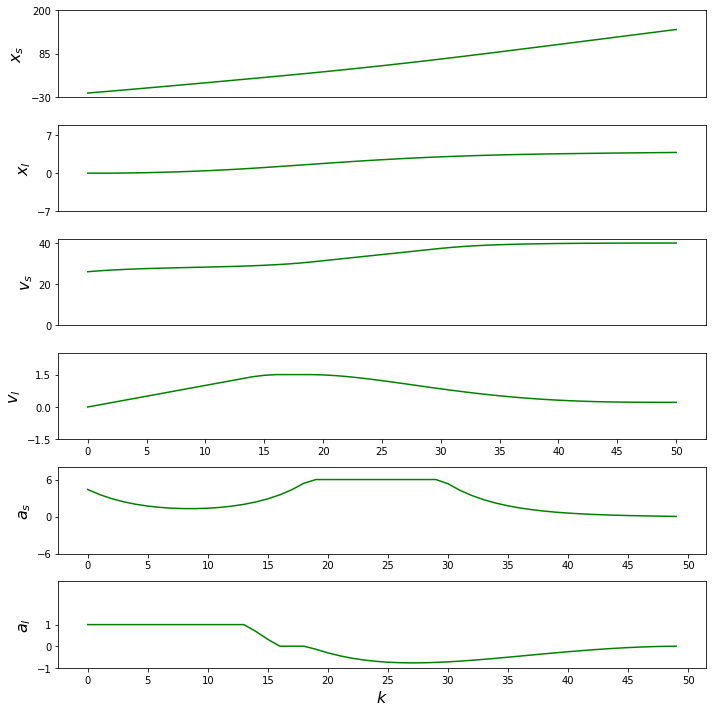

In [10]:
# plot results
plt.figure(figsize=(10, 10))
opt_utils.plot_state_vector(x, u, c)
plt.show()

### **1.6 Visualize solution**

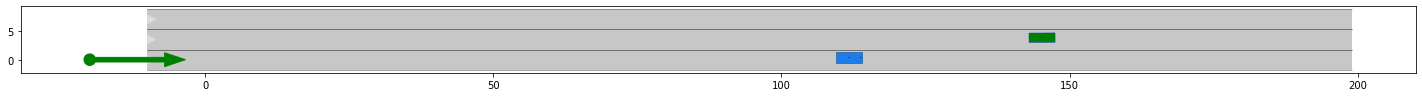

In [11]:
x_result = x.value
s_ego = x_result[0,:].flatten()
l_ego = x_result[1,:].flatten()
v_s_ego = x_result[2,:].flatten()
v_l_ego = x_result[3,:].flatten()

state_list = []
# add init state first
state_list.append(State(**{'position': initial_state.position, 
                           'orientation': initial_state.orientation,
                           'time_step': 0, 
                           }))
for i in range(1, N):
    orientation = initial_state.orientation
    # add new state to state_list    
    state_list.append(State(**{'position': np.array([s_ego[i],l_ego[i]]), 
                               'orientation': math.atan2(v_l_ego[i], v_s_ego[i]),
                               'time_step': i, 
                               }))

# create the planned trajectory starting at time step 0
ego_vehicle_trajectory = Trajectory(initial_time_step=0, state_list=state_list[0:])

# create the prediction using the planned trajectory and the shape of the ego vehicle
ego_vehicle_shape = Rectangle(length=ep.length, width=ep.width)
ego_vehicle_prediction = TrajectoryPrediction(trajectory=ego_vehicle_trajectory,
                                              shape=ego_vehicle_shape)

# the ego vehicle can be visualized by converting it into a DynamicObstacle
ego_vehicle_type = ObstacleType.CAR
ego_vehicle = DynamicObstacle(obstacle_id=101, obstacle_type=ego_vehicle_type,
                              obstacle_shape=ego_vehicle_shape, initial_state=initial_state,
                              prediction=ego_vehicle_prediction)

plt.ion()
plt.figure(figsize=(25, 10))
for i in range(0, N):
    plt.figure(figsize=(25, 10))
    display.clear_output(wait=True)
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    ego_vehicle.draw(rnd, draw_params={'time_begin': i, 'dynamic_obstacle': {
        'vehicle_shape': {'occupancy': {'shape': {'rectangle': {
            'facecolor': 'g'}}}}}})
    planning_problem_set.draw(rnd)
    rnd.render()
    plt.pause(0.1)


***
 # **2. Linearized KST Model with Convex Optimization**
***
### In this example we utilize convex optimization to solve a slightly modified version of the problem above, but with a linearized <a href="https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/-/blob/master/vehicleModels_commonRoad.pdf" target="_blank">KST model</a>. 
### The priori decision is to 
* #### change to left lane;
* #### follow the obstacle on the left lane.

### **2.1 Load scenario and visualize**

In [12]:
## Load the CommonRoad scenario.
file_path = 'tutorial/test_scenarios/itac_optimization_planner_example.xml'
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# problem dimensions
N  = 50  # number of time steps
dT = scenario.dt  # time step

### **2.2 Add another dynamic obstacle into the scenario**


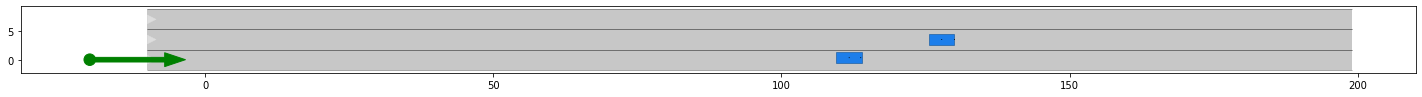

In [13]:
## Add another dynamic obstacle for more fun.
# initial state has a time step of 0
dynamic_obstacle_initial_state = State(position = np.array([20.0, 3.5]),
                                       velocity = 28,
                                       orientation = 0.02,
                                       time_step = 0)

# generate the states for the obstacle for time steps 1 to N by constant velocity
state_list = []
for i in range(1, N+1):
    # compute new position
    new_position = np.array([dynamic_obstacle_initial_state.position[0] + scenario.dt * i * 22, 3.5])
    # create new state
    new_state = State(position = new_position, velocity = 22,orientation = 0.0, time_step = i)
    # add new state to state_list
    state_list.append(new_state)

# create the trajectory of the obstacle, starting at time step 1
dynamic_obstacle_trajectory = Trajectory(1, state_list)

# create the prediction using the trajectory and the shape of the obstacle
dynamic_obstacle_shape = Rectangle(width = 1.8, length = 4.3)
dynamic_obstacle_prediction = TrajectoryPrediction(dynamic_obstacle_trajectory, dynamic_obstacle_shape)

# generate the dynamic obstacle according to the specification
dynamic_obstacle_id = 101
dynamic_obstacle_type = ObstacleType.CAR
dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id,
                                   dynamic_obstacle_type,
                                   dynamic_obstacle_shape,
                                   dynamic_obstacle_initial_state,
                                   dynamic_obstacle_prediction)

# add dynamic obstacle to the scenario
scenario.add_objects(dynamic_obstacle)


## Plot the scenario for each time step.
plt.ion()
plt.figure(figsize=(25, 10))
for i in range(0, N):
    plt.figure(figsize=(25, 10))
    display.clear_output(wait=True)
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    planning_problem_set.draw(rnd)
    rnd.render()
    plt.pause(0.1)

### **2.3 Extract obstacle from scenario**

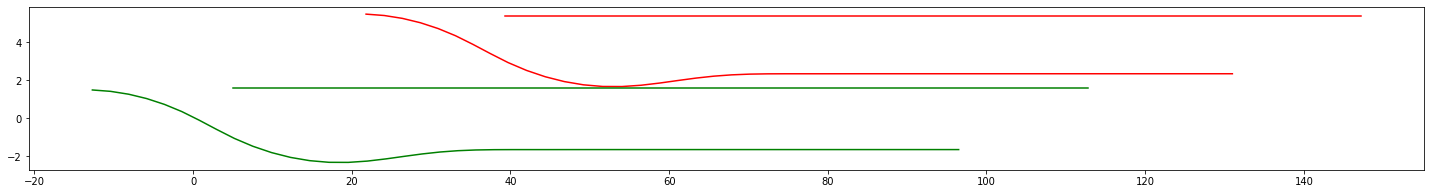

In [14]:
## Get longitudinal and lateral positions of dynamic obstacles in each time step, 
## here we are assuming that the obstacles are observed through out the N time steps with no missings.
dyn_obstacles = scenario.dynamic_obstacles
obstacle_bounds = {}
for o in dyn_obstacles:
    prediction = o.prediction.trajectory.state_list
    obs_id = o.obstacle_id
    obstacle_bound = {
        's_min': [],
        'l_min': [],
        's_max': [],
        'l_max': []
    }
    for i, p in enumerate(prediction):
        obstacle_bound['s_min'].append(p.position[0]-o.obstacle_shape.length/2.-15) # hard coded distances
        obstacle_bound['l_min'].append(p.position[1]-o.obstacle_shape.width/2. - 1)
        obstacle_bound['s_max'].append(p.position[0]+o.obstacle_shape.length/2.+15)
        obstacle_bound['l_max'].append(p.position[1]+o.obstacle_shape.width/2. + 1)
    obstacle_bounds[obs_id] = obstacle_bound
    
    
## Plot bbox motions.
plt.figure(figsize=(25, 3))
for i, (obs_id, obstacle_bound) in enumerate(obstacle_bounds.items()):
    s_min = obstacle_bound['s_min']
    l_min = obstacle_bound['l_min']
    s_max = obstacle_bound['s_max']
    l_max = obstacle_bound['l_max']
    plt.plot(s_min,l_min,'g')
    plt.plot(s_max,l_max,'r')
plt.show()

### **2.4 Optimize lateral waypoints**

#### **2.4.1 Set up the optimization problem**

In [15]:
n  = 4   # length of state vector (x1 = lateral displacement, x2 = tractor yaw, x3 = steering angle, x4 = hitch angle)
m  = 1   # length of input vector (u1 = steering speed)
x = cp.Variable(shape=(n,N+1)) # optimization vector x contains n states per time step 
u = cp.Variable(shape=(m, N)) # optimization vector u contains 1 state
    
# get ego parameters
ep = opt_utils.EgoParametersKST()

# set up constraints
c = opt_utils.ConstraintsKST()
c.x_s_min = -30  # feasible x displacement of vehicle
c.x_s_max = 200  # feasible x displacement of vehicle
c.x_l_min = -7 # feasible y displacement of vehicle
c.x_l_max = 7 # feasible y displacement of vehicle

# set up weights for cost function
w_x_l = 0.8
w_theta = 1000
w_delta = 1000
w_psi = 1
Q = np.eye(n)*np.transpose(np.array([w_x_l,
                                     w_theta,
                                     w_delta,
                                     w_psi
                                     ]))
w_omega = 100
R = np.eye(m)*np.transpose(np.array([w_omega
                                     ]))

# get the initial state of the ego vehicle from the planning problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]
initial_state = planning_problem.initial_state

# reference velocity
v0 = initial_state.velocity
# initial state of vehicle for the optimization problem (lon position , lat position , lon speed, lat speed)
x0 = np.array([initial_state.position[1],
               initial_state.orientation,
               0.0,
               0.0
              ]).reshape([n,])
print('x0:\n', x0)


# set up tractor-trailer kinematics
A = np.add(
            np.array([[0, v0, 0, 0],
                      [0, 0, v0/ep.l_wb, 0],
                      [0, 0, 0, 0],
                      [0, 0, -v0/ep.l_wb, -v0/ep.l_wbt]]) * dT, 
            np.eye(n)
            )
B = np.array([[0],
              [0],
              [1],
              [0]]) * dT 

x0:
 [0. 0. 0. 0.]


The state and input we defined are:
$$
x = [ l , \Psi ,  \delta  , \alpha ]^{T}
$$
$$u = v_{\delta}$$

according to KST kinematic, we have:
$$
\dot x = [v \sin{\Psi}, \frac{v}{l_{wb}}\tan(\delta), v_{\delta}, -v(\frac{\sin{\alpha}}{l_{wb_{t}}} + \frac{\tan{\delta}}{l_{wb}})]^{T}
$$
In order to linearize this, we make two assumptions:
1. $v$ is constant,
2. In highway scenario, $\delta$, $\alpha$ and $\Psi$ are small.

 Hence,
 $$
\dot x = [v \Psi, \frac{v}{l_{wb}}\delta, v_{\delta}, -v(\frac{\alpha}{l_{wb_{t}}} + \frac{\delta}{l_{wb}})]^{T}
$$
 Now we have:
$$
\dot x_{k} = A x_{k} + B u_{k}
$$
where,
$$
A = \begin{bmatrix} 0 & v & 0 & 0 \\ 0 & 0 & \frac{v}{l_{wb}} & 0 \\0 & 0 & 0 & 0 \\0 & 0 & -\frac{v}{l_{wb}} & -\frac{v}{l_{wb_{t}}} \end{bmatrix}
$$
$$
B = \begin{bmatrix} 0  \\ 0 \\1  \\0 \end{bmatrix}
$$
Finally we have the linearized version of kinematic:
$$
x_{k+1} = x_{k} + (A x_{k} + B u_{k})\Delta t 
$$


In [16]:
# target lateral displacement of the left lane (hard coded, from priori decision)
x_l_ref = 3.5

# the optimization problem
cost = 0
# initial state constraint
constr = [x[:,0] == x0]
# constraints
KST_constr = [x[1,:] <= c.yaw_max, x[1,:] >= c.yaw_min]
KST_constr += [x[2,:] <= c.steer_max, x[2,:] >= c.steer_min]
KST_constr += [x[3,:] <= c.hitch_angle_max, x[3,:] >= c.hitch_angle_min]
KST_constr += [u[0, :] <= c.steer_v_max]
KST_constr += [u[0, :] >= c.steer_v_min]

for k in range(N):
    cost += cp.quad_form((x[:,k+1] - np.array([x_l_ref,0,0,0])), Q)\
           + cp.quad_form(u[:, k], R) 
    # time variant state and input constraints
    constr.append(x[:,k+1] == A @ x[:,k] + B @ u[:, k])

    # add obstacle constraint
    for i, (obs_id, obstacle_bbox) in enumerate(obstacle_bounds.items()):
        # here we are assuming that the obstacles are observed through out the N time steps with no missings,
        # and there is only one dynamic obstacle.
        s_min = obstacle_bbox['s_min']
        l_min = obstacle_bbox['l_min']
        s_max = obstacle_bbox['s_max']
        l_max = obstacle_bbox['l_max']
        # constraints for lane change: change to left lane after timestep 25 (hard coded, from priori decision)
        if obs_id == 100:
            if k > 25:
                constr.append(x[0,k+1] - ep.tractor_w / 2.0 >= l_max[k]) 


## Sums problem objectives and concatenates constraints.
# create optimization problem
prob = cp.Problem(cp.Minimize(cost), constr + KST_constr)

#### **2.4.2 Solve the lateral planning problem**

In [17]:
## Solve optimization problem.
prob.solve(verbose=False)
print("Problem is convex: ",prob.is_dcp())
print("Problem solution is "+prob.status)
# print('x:')
# print(x.value)
# print('u:')
# print(u.value)

Problem is convex:  True
Problem solution is optimal


#### **2.4.3 Plot the result**
#### From the plots we can see that the vehicle steers to the left($v_{\delta}$) in the first 10 steps, taking the vehicle to the left lane. You can see the effect of this steering input on the vehicle states ($l$, $\Psi$, $\delta$ and $\alpha$).

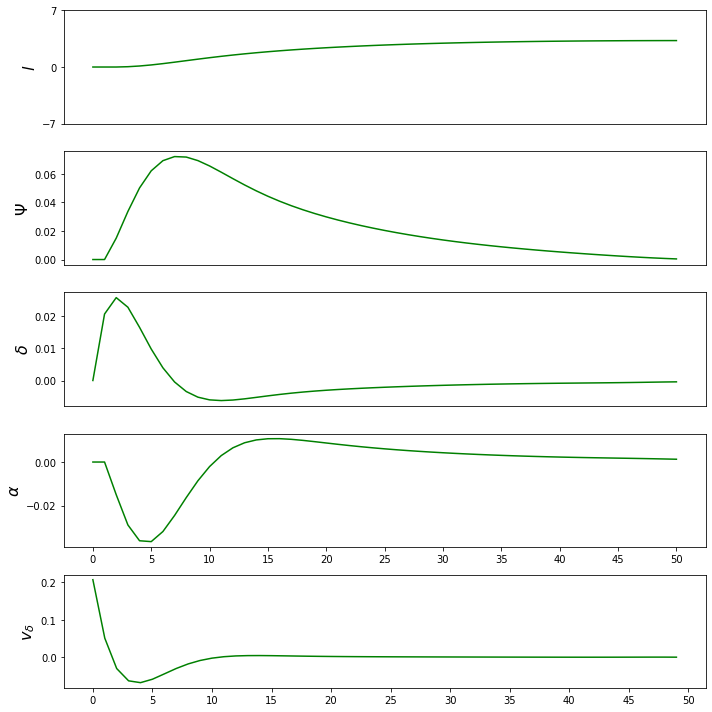

In [18]:
# plot results
plt.figure(figsize=(10, 10))
opt_utils.plot_state_vector_kst(x, u, c)

x_result = x.value

### **2.5 Optimize longitudinal displacement and speed**

#### **2.5.1 Set up the optimization problem**

In [19]:
# problem dimensions
n_lon  = 2   # length of state vector (x1 = longitudinal displacement, x2 = longitudinal speed)
m_lon  = 1   # length of input vector (u1 = longitudinal acceleration)


## Set up the optimization problem.
# set up cvxpy variables
x_lon = cp.Variable(shape=(n_lon,N+1))
u_lon = cp.Variable(shape=(m_lon, N))
# set up weights for cost function
w_x_s = 0
w_v_s = 10
Q_lon = np.eye(n_lon)*np.transpose(np.array([w_x_s,
                                             w_v_s
                                            ]))
w_a_s = 10
R_lon = np.eye(m_lon)*np.transpose(np.array([w_a_s
                                            ]))
# initial state of vehicle for the optimization problem (longitudinal position, longitudinal speed)
x0_lon = np.array([initial_state.position[0],
                  v0
                  ]).reshape([n_lon,])
# set up point mass model kinematics
A_lon = np.add(
            np.array([[0, 1],
                      [0, 0]
                      ]) * dT, 
            np.eye(n_lon)
            )
B_lon = np.array([[0],
                  [1],
                 ]) * dT 

The state and action we defined are:
$$
x = [ l , \dot l]^{T}
$$
$$u = a_{l}$$


Similary we have:
$$
\dot x_{k} = A x_{k} + B u_{k}
$$
where,
$$
A = \begin{bmatrix} 0 & 1 \\ 0 & 0  \end{bmatrix}
$$
$$
B = \begin{bmatrix} 0  \\ 1 \end{bmatrix}
$$

In [20]:
# the optimization problem
cost_lon = 0
# initial state constraint
constr_lon = [x_lon[:,0] == x0_lon]
# velocity constraints
c.v_s_max = 30 # hard coded feasible longitudinal speed
KST_constr_lon = [x_lon[1,:] <= c.v_s_max, x_lon[1,:] >= c.v_s_min]
# add kinematic constraints and calculate cost
for k in range(N):
    cost_lon += cp.quad_form((x_lon[:,k+1] - np.array([0,c.v_s_max])), Q_lon)\
           + cp.quad_form(u_lon[:, k], R_lon)
    # time variant state and input constraints
    constr_lon.append(x_lon[:,k+1] == A_lon @ x_lon[:,k] + B_lon @ u_lon[:, k])
    constr_lon.append(u_lon[0, k] <= c.a_s_max)
    constr_lon.append(u_lon[0, k] >= c.a_s_min)
    # add obstacle constraint
    for i, (obs_id, obstacle_bound) in enumerate(obstacle_bounds.items()):
        # here we are assuming that the obstacles are observed through out the N time steps with no missings,
        # and there is only one dynamic obstacle.
        s_min = obstacle_bound['s_min']
        l_min = obstacle_bound['l_min']
        s_max = obstacle_bound['s_max']
        l_max = obstacle_bound['l_max']
        if obs_id == 100: # do not overtake obstacle 100 until timestep 25 (hard coded, from priori decision)
            if k < 25:
                constr_lon.append(x_lon[0,k] + ep.tractor_l / 2.0 <= s_min[k]) 
        if obs_id == 101: # allways follow obstacle 101 (hard coded, from priori decision)
            constr_lon.append(x_lon[0,k] + ep.tractor_l / 2.0 <= s_min[k]) 


## Sums problem objectives and concatenates constraints.
# create optimization problem
prob_lon = cp.Problem(cp.Minimize(cost_lon), constr_lon + KST_constr_lon)

#### **2.5.2 Solve the longitudinal planning problem**

In [21]:
## Solve optimization problem.
prob_lon.solve(verbose=False)
print("Problem is convex: ",prob_lon.is_dcp())
print("Problem solution is "+prob_lon.status)
# print('x:')
# print(x_lon.value)
# print('u:')
# print(u_lon.value)

Problem is convex:  True
Problem solution is optimal


#### **2.5.3 Plot the result**

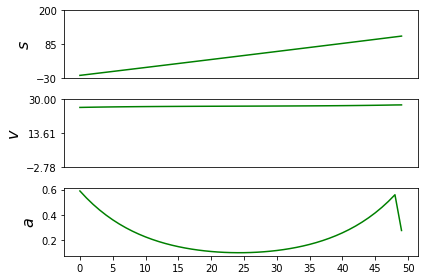

In [22]:
opt_utils.plot_state_vector_lon_kst(x_lon, u_lon, c)
x_result_lon = x_lon.value

### **2.6 Extract, save and visualize the solution for tractor and trailer**


#### We need the bounding box center coordinates of the tractor and the trailer for visualization.


In [23]:
tractor_rear_to_tractor_center = ep.l_total - ep.l_hitch - ep.tractor_l / 2
tractor_rear_to_trailer_center = - ep.l_hitch + ep.trailer_l - ep.trailer_l / 2
def extract_and_derive_tractor_trailer_states_from_x_results(x_result, x_result_lon):
    result = {}
    tractor_rear_axis_x = x_result_lon[0,:].flatten()
    tractor_rear_axis_y = x_result[0,:].flatten()
    result['tractor_orientation'] = x_result[1,:].flatten()
    
    result['tractor_box_x'] = np.asarray([
        tractor_rear_axis_x[i] + tractor_rear_to_tractor_center * math.cos(result['tractor_orientation'][i]) 
        for i in range(N)])
    
    result['tractor_box_y'] = np.asarray([
        tractor_rear_axis_y[i] + tractor_rear_to_tractor_center * math.sin(result['tractor_orientation'][i]) 
        for i in range(N)])  
    
    result['tractor_steer'] = x_result[2,:].flatten()
    result['hitch_angle'] = x_result[3,:].flatten()
    result['tractor_vel'] = x_result_lon[1,:].flatten()
    
    result['trailer_box_x'] = np.asarray([
        tractor_rear_axis_x[i] + tractor_rear_to_trailer_center * math.cos(result['tractor_orientation'][i] + result['hitch_angle'][i])
        for i in range(N)])
    
    result['trailer_box_y'] = np.asarray([
        tractor_rear_axis_y[i] + tractor_rear_to_trailer_center * math.sin(result['tractor_orientation'][i] + result['hitch_angle'][i])
        for i in range(N)])

    return result

state_dic = extract_and_derive_tractor_trailer_states_from_x_results(x_result, x_result_lon)

#### Create a DynamicObstacle of tractor for visualization.

In [24]:
## tractor
state_list = []
# add init state first
state_list.append(State(**{'position': np.array([initial_state.position[0]  + tractor_rear_to_tractor_center * np.cos(initial_state.orientation), 
                                                 initial_state.position[1]  + tractor_rear_to_tractor_center * np.sin(initial_state.orientation)]),
                           'orientation': initial_state.orientation,
                           'time_step': 0, 
                           }))
for i in range(1, N):
    # add new state to state_list    
    state_list.append(State(**{'position': np.array([state_dic['tractor_box_x'][i],state_dic['tractor_box_y'][i]]), 
                               'orientation': state_dic['tractor_orientation'][i],
                               'time_step': i, 
                               }))
# create the planned trajectory starting at time step 0
tractor_trajectory = Trajectory(initial_time_step=0, state_list=state_list[0:])
# create the prediction using the planned trajectory and the shape of the tractor
tractor_shape = Rectangle(length=vehicle4.l, width=vehicle4.w)
tractor_prediction = TrajectoryPrediction(trajectory=tractor_trajectory,
                                              shape=tractor_shape)
# the tractor can be visualized by converting it into a DynamicObstacle
tractor_type = ObstacleType.TRUCK
tractor = DynamicObstacle(obstacle_id=102, obstacle_type=tractor_type,
                              obstacle_shape=tractor_shape, initial_state=initial_state,
                              prediction=tractor_prediction)

#### Create a DynamicObstacle of trailer for visualization.

In [25]:
## treat trailer as another DynamicObstacle just for visualization              
trailer_initial_state = copy.deepcopy(initial_state)
trailer_initial_state.position = [initial_state.position[0] \
                                        + tractor_rear_to_trailer_center * math.cos(initial_state.orientation + initial_state.hitch_angle),
                                    initial_state.position[1] \
                                        + tractor_rear_to_trailer_center * math.sin(initial_state.orientation + initial_state.hitch_angle)
                                 ]
state_list = []
# add init state first
state_list.append(State(**{'position': trailer_initial_state.position, 
                           'orientation': trailer_initial_state.orientation + trailer_initial_state.hitch_angle,
                           'time_step': 0, 
                           }))
for i in range(1, N):
    # add new state to state_list    
    state_list.append(State(**{'position': np.array([state_dic['trailer_box_x'][i],state_dic['trailer_box_y'][i]]), 
                               'orientation': state_dic['tractor_orientation'][i] + state_dic['hitch_angle'][i],
                               'time_step': i, 
                               }))
# create the planned trajectory starting at time step 0
trailer_trajectory = Trajectory(initial_time_step=0, state_list=state_list[0:])
# create the prediction using the planned trajectory and the shape of the trailer
trailer_shape = Rectangle(length=ep.trailer_l,
                          width=ep.trailer_w)
trailer_prediction = TrajectoryPrediction(trajectory=trailer_trajectory,
                                              shape=trailer_shape)
# the trailer can be visualized by converting it into a DynamicObstacle
trailer = DynamicObstacle(obstacle_id=103, obstacle_type=tractor_type,
                              obstacle_shape=trailer_shape, initial_state=trailer_initial_state,
                              prediction=trailer_prediction)

#### Visualization

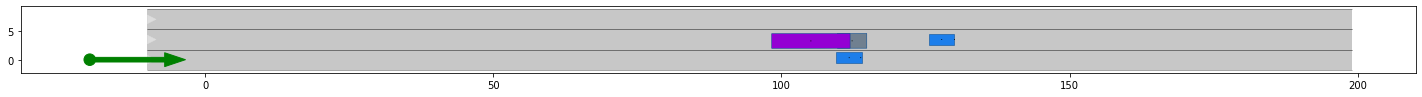

In [26]:
plt.ion()
plt.figure(figsize=(25, 10))
for i in range(0, N):
    plt.figure(figsize=(25, 10))
    display.clear_output(wait=True)
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    tractor.draw(rnd, draw_params={'time_begin': i, 'dynamic_obstacle': {
        'vehicle_shape': {'occupancy': {'shape': {'rectangle': {
            'facecolor': 'slategrey'}}}}}})
    trailer.draw(rnd, draw_params={'time_begin': i, 'dynamic_obstacle': {
        'vehicle_shape': {'occupancy': {'shape': {'rectangle': {
            'facecolor': 'darkviolet'}}}}}})
    planning_problem_set.draw(rnd)
    rnd.render()
    plt.pause(0.1)

***
 # **3. SEMI_TRAILER Model with Nonlinear Optimization**
***
### In section 2, we rely on a priori decision so that we can convert the planning problem into a convex optimization problem, meaning that we have to hand-tune the planner for every scenario. To avoid hand-tuning, it is common to design a decision module to generate decisions for every scenario in real world planners.
### However, what if we want a 'universal' planner that is capable to generate feasible trajectories for most scenarios without a decision module? Though uncommon, generally more complicated and time-consuming, this is achievable if we utilize nonlinear optimization.
### In this section, we will lose the priori decision and use nonlinear optimization to solve the problems with SEMI_TRAILER model with the help of <a href="https://web.casadi.org/" target="_blank">CasADi</a>.


In [27]:
import casadi as ca
from itac.vehiclemodels.parameters_semi_trailer import parameters_semi_trailer
import optimization_planner_example_utils as opt_utils

### **3.1 Get SEMI_TRAILER constraints and parameters**

In [28]:
vehicle_SMT = parameters_semi_trailer()
default_scenario_length = 300

## Semi-trailer constraints.
class ConstraintsSMT: 
    v_s_min = vehicle_SMT.longitudinal.v_min  # feasible min longitudinal velocity
    v_s_max = vehicle_SMT.longitudinal.v_max # feasible max longitudinal velocity

    a_s_min =  -vehicle_SMT.longitudinal.a_max # feasible min longitudinal acceleration
    a_s_max =  vehicle_SMT.longitudinal.a_max # feasible max longitudinal acceleration

    steer_min = vehicle_SMT.steering.min  # minimum steering angle [rad]
    steer_max = vehicle_SMT.steering.max  # maximum steering angle [rad]
    steer_v_min = vehicle_SMT.steering.v_min  # minimum steering velocity [rad/s]
    steer_v_max = vehicle_SMT.steering.v_max  # maximum steering velocity [rad/s]

    yaw_min = -np.pi / 2 # minimum tractor orientation in frenet coordinate sytem [rad]
    yaw_max = np.pi / 2 # maximum tractor orientation in frenet coordinate sytem [rad]

    hitch_angle_min = -np.pi / 2 # minimum angle between tractor and trailer [rad]
    hitch_angle_max = np.pi / 2 # maximum angle between tractor and trailer [rad]

## Semi-trailer parameters.
class EgoParameters:
    tractor_l = vehicle_SMT.l
    tractor_w = vehicle_SMT.w
    # tractor wheelbase
    l_wb = vehicle_SMT.a + vehicle_SMT.b
    # trailer parameters
    trailer_l = vehicle_SMT.trailer.l  # trailer length
    trailer_w = vehicle_SMT.trailer.w  # trailer width
    l_hitch = vehicle_SMT.trailer.l_hitch  # hitch length
    l_total = vehicle_SMT.trailer.l_total  # total system length
    l_wbt = vehicle_SMT.trailer.l_wb  # trailer wheelbase

# get ego parameters
ep = EgoParameters()
# set up constraints
c = ConstraintsSMT()

### **3.2 Load scenario and visualize**
#### This is a highway lane change scenario, the goal is on the left lane.

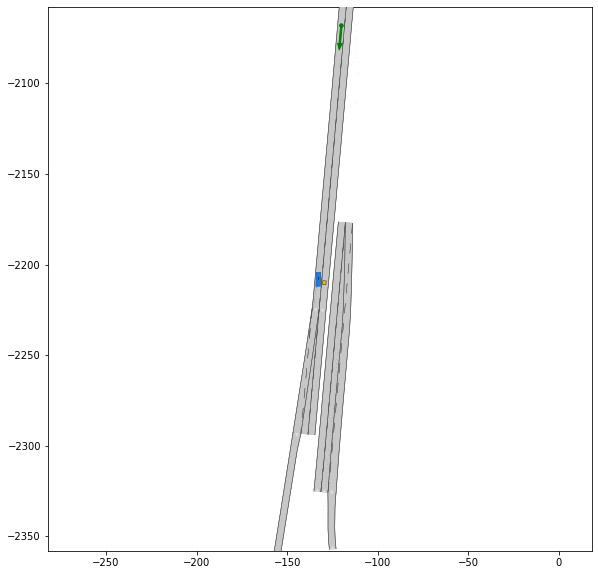

In [29]:
## Load the CommonRoad scenario.
file_path = 'scenarios/highway/CHN_LC-1_1_T-1.xml'
N = 65 # hard coded here.
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()
## Plot the scenario for each time step.
plt.ion()
plt.figure(figsize=(25, 10))
for i in range(0, N):
    plt.figure(figsize=(25, 10))
    display.clear_output(wait=True)
    rnd = MPRenderer()
    window_size = 150
    rnd.plot_limits = [-window_size,
                        window_size, -window_size, window_size]
    scenario.draw(rnd, draw_params={
        'time_begin': i, 'focus_obstacle_id': scenario.dynamic_obstacles[0].obstacle_id})
    scenario.draw(rnd, draw_params={'time_begin': i})
    planning_problem_set.draw(rnd)
    rnd.render()
    plt.pause(0.1)

### **3.3 Extract obstacle from scenario**
#### Here we fill the dynamic obstalces with spheres along their longitudinal directions for **a dummy collision check**. The blue rectangle is a dynamic obstacle and the yellow spheres are to replace the rectangle as the obstacle's collision volume. 
![ds](pics/simple_collision_check.png)

#### **Please be noted that** in this section, we are neglecting the lane boundaries, which are supposed to be handled in your planners.

In [30]:
## Get dynamic obstacles info in each time step.
dyn_obstacles = scenario.dynamic_obstacles
obstacle_info = {}
for o in dyn_obstacles:
    obs_id = str(o.obstacle_id)
    if obs_id not in obstacle_info.keys():
        obstacle_info[obs_id] = {}
        obstacle_info[obs_id]['initial_time_step'] = o.prediction.initial_time_step
        obstacle_info[obs_id]['final_time_step'] = o.prediction.final_time_step
        obstacle_info[obs_id]['shape'] = [o.prediction.shape.length, o.prediction.shape.width]
        # get sphere centers for a dummy collision check
        shape = obstacle_info[obs_id]['shape']
        collision_sphere_centers_first = shape[0] / 2 - shape[1] / 2
        collision_sphere_centers_last = - collision_sphere_centers_first
        total_sphere = math.ceil(shape[0] / shape[1])
        num_to_fill = total_sphere - 2
        displacement_unit_length = shape[0] / (num_to_fill + 1)
        collision_sphere_centers = [collision_sphere_centers_first] \
                                   + [collision_sphere_centers_first - j * displacement_unit_length for j in range(1, num_to_fill+1)] \
                                   + [collision_sphere_centers_last]
        obstacle_info[obs_id]['collision_sphere_centers'] = collision_sphere_centers
        obstacle_info[obs_id]['bbox'] = {}
 
    prediction = o.prediction.trajectory.state_list
    for i, p in enumerate(prediction):
        obstacle_info[obs_id]['bbox'][p.time_step] = [p.position[0], p.position[1], p.orientation]

### **3.4 Get initial and goal state**

In [31]:
## Problem dimensions.
n = 9   # length of state vector
# x1 = x-position in a global coordinate system, tractor
# x2 = y-position in a global coordinate system, tractor
# x3 = steering angle of front wheels
# x4 = velocity in longitudinal direction
# x5 = yaw angle, tractor
# x6 = hitch angle
# x7 = x-position in a global coordinate system, trailer
# x8 = y-position in a global coordinate system, trailer
# x9 = yaw angle, trailer

m = 2 # length of the input vector
# u1 = steering angle velocity of front wheels
# u2 = longitudinal acceleration

# time step
dT = scenario.dt  


In [32]:
## Get the initial state of the ego vehicle from the planning problem set.
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]
initial_state = planning_problem.initial_state
x0 = np.array([initial_state.position[0],
               initial_state.position[1],
               initial_state.yaw_rate,
               initial_state.velocity,
               initial_state.orientation,
               0.0, # hitch angle at initial state, default value = 0.0
               initial_state.position[0] - ep.l_wbt * math.cos(initial_state.orientation),
               initial_state.position[1] - ep.l_wbt * math.sin(initial_state.orientation),
               initial_state.orientation
               ]).reshape([n,])
print('x0:\n', x0)


## Get the goal region of the problem.
goal_state = planning_problem.goal.state_list[0]
goal_position = goal_state.position
goal_x = goal_position.center[0] 
goal_y = goal_position.center[1]
goal_yaw = goal_state.position.orientation

print('goal:\n', goal_x, goal_y, goal_yaw)

x0:
 [-1.20056814e+02 -2.06815477e+03  0.00000000e+00  1.98000000e+01
 -1.66024000e+00  0.00000000e+00 -1.19333286e+02 -2.06008715e+03
 -1.66024000e+00]
goal:
 -129.5 -2210.0 -1.66024


### **3.5 Set up the optimization problem**

In [33]:
## Set up the optimization problem.
opti = ca.Opti() # Optimization problem
# set up CasADi variables
X = opti.variable(n,N+1) # state trajectory
x      = X[0,:]
y      = X[1,:]
delta  = X[2,:]
v_x    = X[3,:]
psi    = X[4,:]
alpha  = X[5,:]
x_tl   = X[6,:]
y_tl   = X[7,:]
psi_tl = X[8,:]
U = opti.variable(m,N)   # control trajectory 
# set up weights for cost function
w_x     = 10
w_y     = 10
w_delta = 100000
w_v_x   = 100
w_psi = 0
w_alpha = 10000
w_x_tl   = 0
w_y_tl   = 0
w_psi_tl = 0
Q = np.eye(n)*np.transpose(np.array([w_x,
                                     w_y,
                                     w_delta,
                                     w_v_x,
                                     w_psi,
                                     w_alpha,
                                     w_x_tl,
                                     w_y_tl,
                                     w_psi_tl
                                     ]))
w_v_delta = 10000000
w_acc = 10000
R = np.eye(m)*np.transpose(np.array([w_v_delta,
                                     w_acc
                                     ]))

# the optimization problem
cost = 0
# initial state constraint
opti.subject_to(X[:, 0] == x0)
# goal state constraint
opti.subject_to(ca.sqrt(ca.power((X[0, -1] - goal_x), 2) + ca.power((X[1, -1] - goal_y), 2)) <= 0.1)
opti.subject_to(ca.sqrt(ca.power((X[4, -1] - goal_yaw), 2)) <= 0.05)
# other constraints
opti.subject_to(X[2,:] <= c.steer_max)
opti.subject_to(X[2,:] >= c.steer_min)
opti.subject_to(X[3,:] <= c.v_s_max + 6)
opti.subject_to(X[3,:] >= 0)
opti.subject_to(X[5,:] <= c.hitch_angle_max)
opti.subject_to(X[5,:] >= c.hitch_angle_min)
opti.subject_to(U[0,:] <= c.steer_v_max)
opti.subject_to(U[0,:] >= c.steer_v_min)
# the kinematics of semi-trailer, check vehicle_dynamics_semi_trailer.py for details
f = lambda x, u: ca.vertcat(x[3] * ca.cos(x[4]),
                            x[3] * ca.sin(x[4]),
                            u[0],
                            u[1],
                            x[3] / ep.l_wb * ca.tan(x[2]),
                            -x[3] * (ca.sin(x[5]) / ep.l_wbt + ca.tan(x[2]) / ep.l_wb),
                            x[3] * ca.cos(x[4]) \
                                + ep.l_wbt * ca.sin(x[8]) * (x[3] / ep.l_wb * ca.tan(x[2]) \
                                + -x[3] * (ca.sin(x[5]) / ep.l_wbt + ca.tan(x[2]) / ep.l_wb)),
                            x[3] * ca.sin(x[4]) \
                                - ep.l_wbt * ca.cos(x[8]) * (x[3] / ep.l_wb * ca.tan(x[2]) \
                                + -x[3] * (ca.sin(x[5]) / ep.l_wbt + ca.tan(x[2]) / ep.l_wb)),
                            x[3] / ep.l_wb * ca.tan(x[2]) \
                                + -x[3] * (ca.sin(x[5]) / ep.l_wbt + ca.tan(x[2]) / ep.l_wb)
                            )
for k in range(N):
    opti.subject_to(X[:, k+1] == X[:, k] + dT * f(X[:, k], U[:, k]))
    x_tmp = X[:,k+1] - np.array([goal_x,goal_y,0, c.v_s_max, 0, 0, 0, 0, 0])
    cost += x_tmp.T @ Q @ x_tmp
    cost += U[:, k].T @ R @ U[:, k]

    # acceleration constraints
    opti.subject_to(U[1,k] <= c.a_s_max - 0.1 * X[3,k])     # a dummpy method to limit accelerations
    opti.subject_to(U[1,k] >= c.a_s_min)

    # dummy collision check with obstacles
    for i, (key, obs) in enumerate(obstacle_info.items()):
        if k < obs['initial_time_step'] or k > obs['final_time_step']:
            continue
        if k not in obs['bbox'].keys():
            continue
        
        obs_x     = obs['bbox'][k][0]
        obs_y     = obs['bbox'][k][1]
        obs_yaw   = obs['bbox'][k][2]
        obs_shape = obs['shape']

        # using spheres as collision volumes
        # assuming ego's hitch angle is small in highway scenarios
        ego_sphere_d = ep.tractor_w
        ego_collision_sphere_centers_first = 3.225
        ego_collision_sphere_centers = [ego_collision_sphere_centers_first] + \
            [ego_collision_sphere_centers_first - j * ego_sphere_d for j in range(1, 6)]
        obs_collision_sphere_centers = obs['collision_sphere_centers']

        for ego_cs in ego_collision_sphere_centers:
            for obs_cs in obs_collision_sphere_centers:
                x_diff = (X[0,k] + ego_cs * ca.cos(X[4, k])) - (obs_x + obs_cs * math.cos(obs_yaw))
                y_diff = (X[1,k] + ego_cs * ca.sin(X[4, k])) - (obs_y + obs_cs * math.sin(obs_yaw))
                opti.subject_to(ca.sqrt(ca.power(x_diff, 2) + ca.power(y_diff, 2)) >= (ego_sphere_d / 2 + obs_shape[1] / 2 + 0.1))

### **3.6 Solve the planning problem**

In [34]:
## Sums problem objectives and concatenates constraints.
# create optimization problem
opti.minimize(cost)
opti.solver("ipopt") # set numerical backend
## Solve optimization problem.
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2674
Number of nonzeros in inequality constraint Jacobian.:     5404
Number of nonzeros in Lagrangian Hessian.............:     3135

Total number of variables............................:      724
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

### **3.7 Plot result**

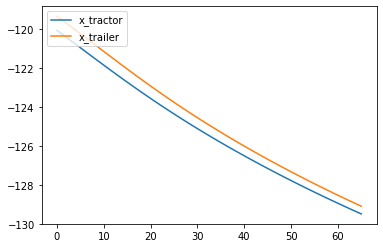

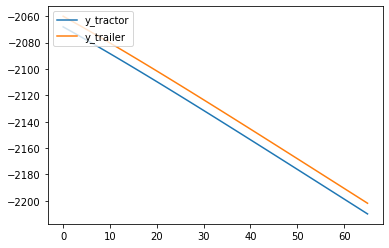

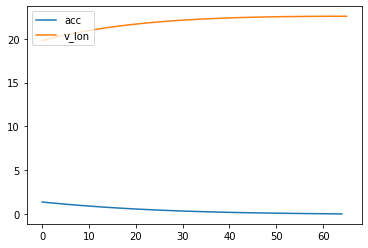

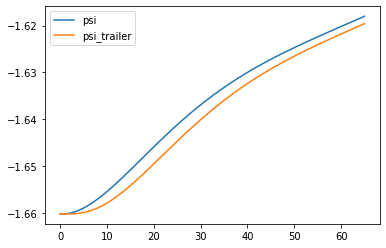

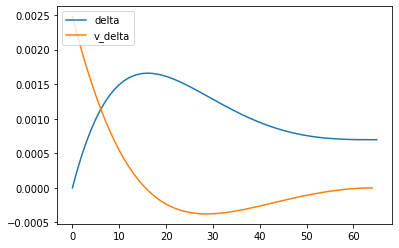

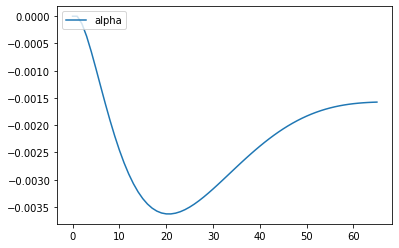

In [35]:
plt.ion()
plt.plot(sol.value(X[0, :]),label="x_tractor")
plt.plot(sol.value(X[6, :]),label="x_trailer")
plt.legend(loc="upper left")
plt.show(block=True)

plt.plot(sol.value(X[1, :]),label="y_tractor")
plt.plot(sol.value(X[7, :]),label="y_trailer")
plt.legend(loc="upper left")
plt.show(block=True)

plt.plot(sol.value(U[1, :]),label="acc")
plt.plot(sol.value(X[3, :]),label="v_lon")
plt.legend(loc="upper left")
plt.show(block=True)

plt.plot(sol.value(X[4, :]),label="psi")
plt.plot(sol.value(X[8, :]),label="psi_trailer")
plt.legend(loc="upper left")
plt.show(block=True)

plt.plot(sol.value(X[2, :]),label="delta")
plt.plot(sol.value(U[0, :]),label="v_delta")
plt.legend(loc="upper left")
plt.show(block=True)

plt.plot(sol.value(X[5, :]),label="alpha")
plt.legend(loc="upper left")
plt.show(block=True)

# print(sol.value(X[4, :]))

### **3.8 Extract, visualize and save the solution for tractor and trailer**

In [36]:
def extract_and_derive_tractor_trailer_state_from_results(x_result):
    result = {}
    result['tractor_pos_x'] = x_result[0,:].flatten()
    result['tractor_pos_y'] = x_result[1,:].flatten()
    result['tractor_steer'] = x_result[2,:].flatten()
    result['tractor_vel'] = x_result[3,:].flatten()
    result['tractor_orientation'] = x_result[4,:].flatten()
    result['hitch_angle'] = x_result[5,:].flatten()
    result['trailer_pos_x'] = x_result[6,:].flatten()
    result['trailer_pos_y'] = x_result[7,:].flatten()
    result['trailer_orientation'] = x_result[8,:].flatten()
    return result

state_dic = extract_and_derive_tractor_trailer_state_from_results(sol.value(X))

#### **3.8.1 Create tractor DynamicObstalce**

In [37]:
tractor_rear_to_tractor_center = ep.l_total - ep.l_hitch - ep.tractor_l / 2
tractor_rear_to_trailer_center = - (ep.trailer_l - ep.l_hitch) + ep.trailer_l / 2
trailer_rear_to_trailer_center = ep.l_wbt - ep.l_hitch + ep.trailer_l / 2

## tractor DynamicObstacle for simulation
state_list = []
# add init state first
state_list.append(State(**{'position': np.array([
                                initial_state.position[0] \
                                    + tractor_rear_to_tractor_center * math.cos(initial_state.orientation), 
                                initial_state.position[0] \
                                    + tractor_rear_to_tractor_center * math.sin(initial_state.orientation)
                                ]),
                           'orientation': initial_state.orientation,
                           'time_step': 0
                           }))
for i in range(1, N):
    # add new state to state_list    
    state_list.append(State(**{'position': np.array([
                                    state_dic['tractor_pos_x'][i] \
                                        + tractor_rear_to_tractor_center * math.cos(state_dic['tractor_orientation'][i]), 
                                    state_dic['tractor_pos_y'][i] \
                                        + tractor_rear_to_tractor_center * math.sin(state_dic['tractor_orientation'][i])
                                    ]), 
                               'orientation': state_dic['tractor_orientation'][i],
                               'time_step': i
                              }))

# create the planned trajectory starting at time step 0
tractor_trajectory = Trajectory(initial_time_step=0, state_list=state_list[0:])
# create the prediction using the planned trajectory and the shape of the tractor
tractor_shape = Rectangle(length=ep.tractor_l, 
                          width=ep.tractor_w)
tractor_prediction = TrajectoryPrediction(trajectory=tractor_trajectory,
                                              shape=tractor_shape)
# the tractor can be visualized by converting it into a DynamicObstacle
tractor_type = ObstacleType.TRUCK
tractor = DynamicObstacle(obstacle_id=100, obstacle_type=tractor_type,
                              obstacle_shape=tractor_shape, initial_state=initial_state,
                              prediction=tractor_prediction)

#### **3.8.2 Create trailer DynamicObstalce**

In [38]:
## treat trailer as another DynamicObstacle JUST for visualization.              
state_list = []
# add init state first
state_list.append(State(**{'position': np.asarray([
                                initial_state.position[0] \
                                    - (ep.l_wbt + trailer_rear_to_trailer_center) * math.cos(initial_state.orientation),
                                initial_state.position[1] \
                                    - (ep.l_wbt + trailer_rear_to_trailer_center) * math.sin(initial_state.orientation),
                                ]), 
                           'orientation':initial_state.orientation,
                           'time_step': 0, 
                           }))
for i in range(1, N):
    # add new state to state_list    
    state_list.append(State(**{'position': np.array([
                                    state_dic['trailer_pos_x'][i] \
                                        + trailer_rear_to_trailer_center * math.cos(state_dic['trailer_orientation'][i]), 
                                    state_dic['trailer_pos_y'][i] \
                                        + trailer_rear_to_trailer_center * math.sin(state_dic['trailer_orientation'][i])
                                    ]),
                                'orientation': state_dic['trailer_orientation'][i],
                                'time_step': i, 
                                }))
# create the planned trajectory starting at time step 0
trailer_trajectory = Trajectory(initial_time_step=0, state_list=state_list[0:])
# create the prediction using the planned trajectory and the shape of the trailer
trailer_shape = Rectangle(length=ep.trailer_l,
                          width=ep.trailer_w)
trailer_prediction = TrajectoryPrediction(trajectory=trailer_trajectory,
                                              shape=trailer_shape)
# the trailer can be visualized by converting it into a DynamicObstacle
trailer = DynamicObstacle(obstacle_id=100, obstacle_type=tractor_type,
                              obstacle_shape=trailer_shape, initial_state=initial_state,
                              prediction=trailer_prediction)

#### **3.8.3 Visualize solution**

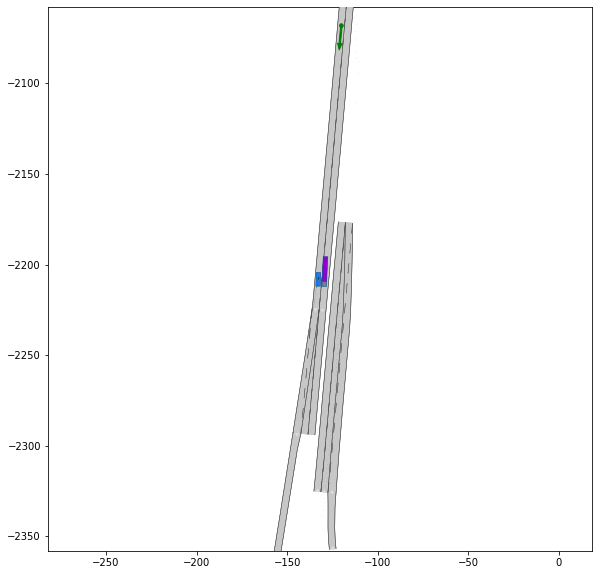

In [39]:
## Visualization.
plt.ion()
plt.figure(figsize=(25, 10))
# plot the scenario and the ego vehicle for each time step
for i in range(0, N):
    plt.figure(figsize=(25, 10))
    display.clear_output(wait=True)
    rnd = MPRenderer()
    window_size = 150
    rnd.plot_limits = [-window_size,
                        window_size, -window_size, window_size]
    scenario.draw(rnd, draw_params={
        'time_begin': i, 'focus_obstacle_id': scenario.dynamic_obstacles[0].obstacle_id})
    scenario.draw(rnd, draw_params={'time_begin': i})
    tractor.draw(rnd, draw_params={'time_begin': i, 'dynamic_obstacle': {
        'vehicle_shape': {'occupancy': {'shape': {'rectangle': {
            'facecolor': 'slategrey'}}}}}})
    trailer.draw(rnd, draw_params={'time_begin': i, 'dynamic_obstacle': {
        'vehicle_shape': {'occupancy': {'shape': {'rectangle': {
            'facecolor': 'darkviolet'}}}}}})
    planning_problem_set.draw(rnd)
    rnd.render()
    plt.pause(0.1)

#### **3.8.4 Save solution**

In [40]:
## tractor for submit
state_list = []
# add init state first
state_list.append(State(**{'position': initial_state.position, 
                           'steering_angle': 0.0,
                           'velocity':initial_state.velocity,
                           'orientation': initial_state.orientation,
                           'hitch_angle': 0.0,
                           'position_trailer': np.array([
                               initial_state.position[0] - ep.l_wbt * math.cos(initial_state.orientation),
                               initial_state.position[1] - ep.l_wbt * math.sin(initial_state.orientation)
                           ]),
                           'yaw_angle_trailer': initial_state.orientation,
                           'time_step': 0
                           }))
for i in range(1, N):
    # add new state to state_list    
    state_list.append(State(**{'position': np.array([
                                    state_dic['tractor_pos_x'][i], 
                                    state_dic['tractor_pos_y'][i]
                                    ]), 
                               'steering_angle': state_dic['tractor_steer'][i],
                               'velocity': state_dic['tractor_vel'][i],
                               'orientation': state_dic['tractor_orientation'][i],
                               'hitch_angle': state_dic['hitch_angle'][i],
                               'position_trailer': np.array([
                                   state_dic['trailer_pos_x'][i],
                                   state_dic['trailer_pos_y'][i]
                               ]),
                               'yaw_angle_trailer': state_dic['trailer_orientation'][i],
                               'time_step': i, 
                              }))

# create the planned trajectory starting at time step 0
tractor_trajectory = Trajectory(initial_time_step=0, state_list=state_list[0:])
# create the prediction using the planned trajectory and the shape of the tractor
tractor_shape = Rectangle(length=ep.tractor_l, 
                          width=ep.tractor_w)
tractor_prediction = TrajectoryPrediction(trajectory=tractor_trajectory,
                                              shape=tractor_shape)
# the tractor can be visualized by converting it into a DynamicObstacle
tractor_type = ObstacleType.TRUCK
tractor = DynamicObstacle(obstacle_id=100, obstacle_type=tractor_type,
                              obstacle_shape=tractor_shape, initial_state=initial_state,
                              prediction=tractor_prediction)


# trajectory_solution是已生成的Trajectory
# 创建 PlanningProblemSolution 对象
kwarg = {'planning_problem_id': planning_problem.planning_problem_id,
         # 指定车辆模型
         'vehicle_model': VehicleModel.SEMI_TRAILER,
         # 指定车辆类型
         'vehicle_type': VehicleType.SEMI_TRAILER,
         # 代价函数，请使用ST
         'cost_function': CostFunction.ST,
         'trajectory': tractor_prediction.trajectory}

planning_problem_solution = PlanningProblemSolution(**kwarg)

# 创建Solution对象
kwarg = {'scenario_id': scenario.scenario_id,
         'planning_problem_solutions': [planning_problem_solution]}

solution = Solution(**kwarg)


dir_output = "./outputs/solutions/"
if not os.path.exists(dir_output):
    os.makedirs(dir_output)
# 生成解答文件
csw = CommonRoadSolutionWriter(solution)
csw.write_to_file(output_path=dir_output, overwrite=True)